## Baseline CL for Split-MNIST

Implementation of baseline continual learning pipeline for Split-MNIST task

In [13]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import torch
torch.random.manual_seed(0xBADBEEF)

import os, sys
sys.path.append("..")
from frcl.datasets.split_mnist import SplitMnistDataset
from frcl.models import SplitMnistModel
from frcl.frcl import DeterministicCLBaseline
from torch.utils.data import DataLoader
from frcl.utils import CLDataLoader, cl_batch_to_device, cl_batch_target_float
from frcl.experiments.estimators import AccuracyTasksEstimator
import seaborn as sns
sns.set()

### Utility functions

In [2]:
def make_x_y(hist):
    x = np.concatenate([np.linspace(i, i + 1, len(hist[i]), endpoint=False) for i in range(len(hist))])
    y = np.concatenate([np.asarray(epoch_hist) for epoch_hist in hist])
    return x, y

def train_model_once(train_loader, cl_model, optim, device):
    loss_hist = []
    curr_loss = 0.
    upd_factor = 20
    i = 0
    for X, target in train_loader:
        X.to(device)
        target = target.float()
        target.to(device)
        optim.zero_grad()
        loss = cl_model(X, target)
        loss.backward()
        optim.step()
        curr_loss += loss.item()
        if (i + 1) % upd_factor == 0:
            curr_loss /= upd_factor
            loss_hist.append(curr_loss)
            curr_loss = 0
        i += 1
    return loss_hist

def train_model(train_loader, cl_model, optim, max_epochs, device, name='cl'):
    loss_hist = []
    for e in range(max_epochs):
        loss = train_model_once(train_loader, cl_model, optim, device)
        loss_hist.append(loss)
        clear_output(wait=True)

        x, y = make_x_y(loss_hist)
        plt.plot(x, y)
        plt.title('Loss_{}'.format(name))
        plt.show()
    return make_x_y(loss_hist)

### Configuration setup

In [3]:
batch_size = 100
learning_rate = 1e-4
device = 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

In [4]:
base_model = SplitMnistModel()
cl_model = DeterministicCLBaseline(base_model, base_model.hid, device=device)
acc_estimator = AccuracyTasksEstimator()
losses = []

### Sequential tasks solving 

In [5]:
tasks = [(0, 1), (2, 3), (4 ,5), (6, 7), (8, 9)]

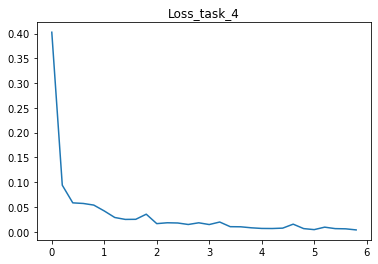

In [6]:
for i, lbls in enumerate(tasks):
    lbl_0, lbl_1 = lbls
    train_ds = SplitMnistDataset(lbl_0, lbl_1, normalize=True)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = SplitMnistDataset(lbl_0, lbl_1, train=False)
    acc_estimator.register_task(test_ds)
    cl_model.create_new_task()
    optim = torch.optim.Adam(cl_model.parameters(), lr=learning_rate)
    x, y = train_model(train_dl, cl_model, optim, (i + 2), device, name='task_{}'.format(i))
    losses.append((x, y))
    cl_model.select_inducing(train_ds, N=10)
    acc_estimator(cl_model)

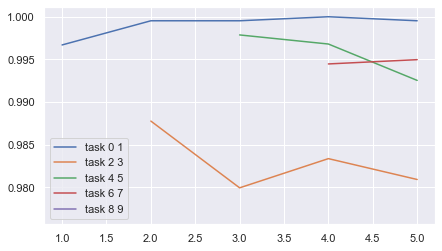

In [16]:
fig = plt.figure(figsize=(7, 4))
for i, lbls in enumerate(tasks):
    lbl0, lbl1 = lbls
    x, y = acc_estimator.get_task_estimations(i)
    plt.plot(x, y, label = "task {} {}".format(lbl0, lbl1))
    plt.legend()
plt.show()